In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_gaussian_quantiles, make_moons, make_circles, make_blobs
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
import modules.complexity_estimator as ce
import modules.util as u
from modules.oracle import Oracle
from nd_boundary_plot.plots import nd_boundary_plot


################################################################################################33
#scatter plot of a dataset helper
#
def plot_ds(grid_size, loc, X, y, xx, yy, title, seeds=None, colspan=1, rowspan=1):

    ax = plt.subplot2grid(grid_size, loc, rowspan=rowspan, colspan=colspan)

    ax.set_title(title)
    # Plot also the training points
    ax.scatter(X[:, 0],X[:, 1], c=y)
    # and seeds
    if seeds is not None:
        ax.scatter(X[seeds, 0], X[seeds, 1],
                   alpha=1.0, facecolors='magenta')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

#perform active learning
#
def active(classifiers, datasets, experiments, quota=25, plot_every_n=5):
    # USE THIS INSTEAD OF YTGT WHICH WE PRETEND TO NOT KNOW

    for dsix, ((X_src, y_src), (X_tgt, y_tgt)) in enumerate(datasets):
        u_tgt = [None] * len(X_tgt)
        est_src = ce.ComplexityEstimator(X_src, y_src)
        est_tgt = ce.ComplexityEstimator(X_tgt, y_tgt)
        # declare Dataset instance, X is the feature, y is the label (None if unlabeled)
        X = np.vstack((X_src, X_tgt))

        h = .05  # step size in the mesh
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        figure = plt.figure(figsize=(27, 13))

        grid_size = (1+len(classifiers), 6)
        for n, classifier in enumerate(classifiers):
            model = classifier
            oracle = Oracle(X_tgt, y_tgt)
            # plot src
            plot_ds(grid_size, (0, 0), X_src, y_src, xx, yy, 'Src', est_src.seeds)
            ax = plt.subplot2grid(grid_size, (0,1), colspan=2)
            ax.set_title('Src complexity')
            Ks, Es = est_src.get_k_complexity()
            ax.plot(Ks, Es)
            #plt tgt
            plot_ds(grid_size, (0, 3), X_tgt, y_tgt, xx, yy, 'Tgt', est_tgt.seeds)
            ax = plt.subplot2grid(grid_size, (0,4), colspan=2)
            Ks, Es = est_tgt.get_k_complexity()
            ax.set_title('Tgt complexity')
            ax.plot(Ks, Es)
            w = 0
            X_known = X_src.tolist()
            y_known = y_src.tolist()
            for i in range(quota):  # loop through the number of queries
                loc, y_loc = oracle.random_query()  # let the specified QueryStrategy suggest a data to query
                u_tgt[loc] = y_loc
                X_known.append(X_tgt[loc])
                y_known.append(y_tgt[loc])
                if i == 0 or i % plot_every_n == 0 or i == quota - 1:
                    model.fit(X_known, y_known)  # train model with newly-updated Dataset
                    score = model.score(X_tgt, y_tgt)
                    ax = plt.subplot2grid(grid_size, (n + 1, w))
                    nd_boundary_plot(X_tgt, model, (x_min, x_max, y_min, y_max), ax)
                    if i == 0:
                        ax.set_ylabel(u.classname(model))
                    if n == 0:
                        ax.set_title('# queries=' + str(i))
                    ax.set_xlabel('Accuracy='+('%.2f' % score).lstrip('0'))
                    w += 1

        figure.suptitle(experiments[dsix])
        figure.tight_layout()
        fname = './vis/' + str(experiments[dsix]) + '.png'
        figure.savefig(filename=fname)
    plt.show()

In [65]:
def load_yeast_data():
    yeast = pd.read_csv('./data/yeast.csv', delim_whitespace=True)
    
    # Assign names to Columns
    yeast.columns = ['seq_name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'alm3', 'site']

    yeast = yeast.drop('seq_name', axis=1)
    yeast = yeast.drop('alm1', axis=1)
    
    
    # Encode Data
    yeast.site.replace(('MIT', 'NUC', 'CYT', 'ME1', 'EXC', 'ME2', 'ME3', 'VAC', 'POX', 'ERL'),(1,2,3,4,5,6,7,8,9,10), inplace=True)
    
    yeast = yeast.values
    X = yeast[:,0:7]
    y = yeast[:,7] 
    
    return X, y

In [66]:
def load_ecoli_data():
    ecoli = pd.read_csv("./data/ecoli.csv", delim_whitespace=True)
    
    # Assign names to Columns
    ecoli.columns = ['seq_name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'site']

    ecoli = ecoli.drop('seq_name', axis=1)

    # Encode Data
    ecoli.site.replace(('cp', 'im', 'pp', 'imU', 'om', 'omL', 'imL', 'imS'),(1,2,3,4,5,6,7,8), inplace=True)
    
    ecoli = ecoli.values
    X = ecoli[:,0:7]
    y = ecoli[:,7] 
    
    return X, y

In [67]:
load_ecoli_data()

(array([[ 0.07,  0.4 ,  0.48, ...,  0.54,  0.35,  0.44],
        [ 0.56,  0.4 ,  0.48, ...,  0.49,  0.37,  0.46],
        [ 0.59,  0.49,  0.48, ...,  0.52,  0.45,  0.36],
        ..., 
        [ 0.61,  0.6 ,  0.48, ...,  0.44,  0.39,  0.38],
        [ 0.59,  0.61,  0.48, ...,  0.42,  0.42,  0.37],
        [ 0.74,  0.74,  0.48, ...,  0.31,  0.53,  0.52]]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 

In [69]:
load_yeast_data()

(array([[ 0.43,  0.67,  0.48, ...,  0.5 ,  0.53,  0.22],
        [ 0.64,  0.62,  0.49, ...,  0.5 ,  0.53,  0.22],
        [ 0.58,  0.44,  0.57, ...,  0.5 ,  0.54,  0.22],
        ..., 
        [ 0.67,  0.57,  0.36, ...,  0.5 ,  0.56,  0.22],
        [ 0.43,  0.4 ,  0.6 , ...,  0.5 ,  0.53,  0.39],
        [ 0.65,  0.54,  0.54, ...,  0.5 ,  0.53,  0.22]]),
 array([ 1.,  1.,  2., ...,  6.,  2.,  3.]))

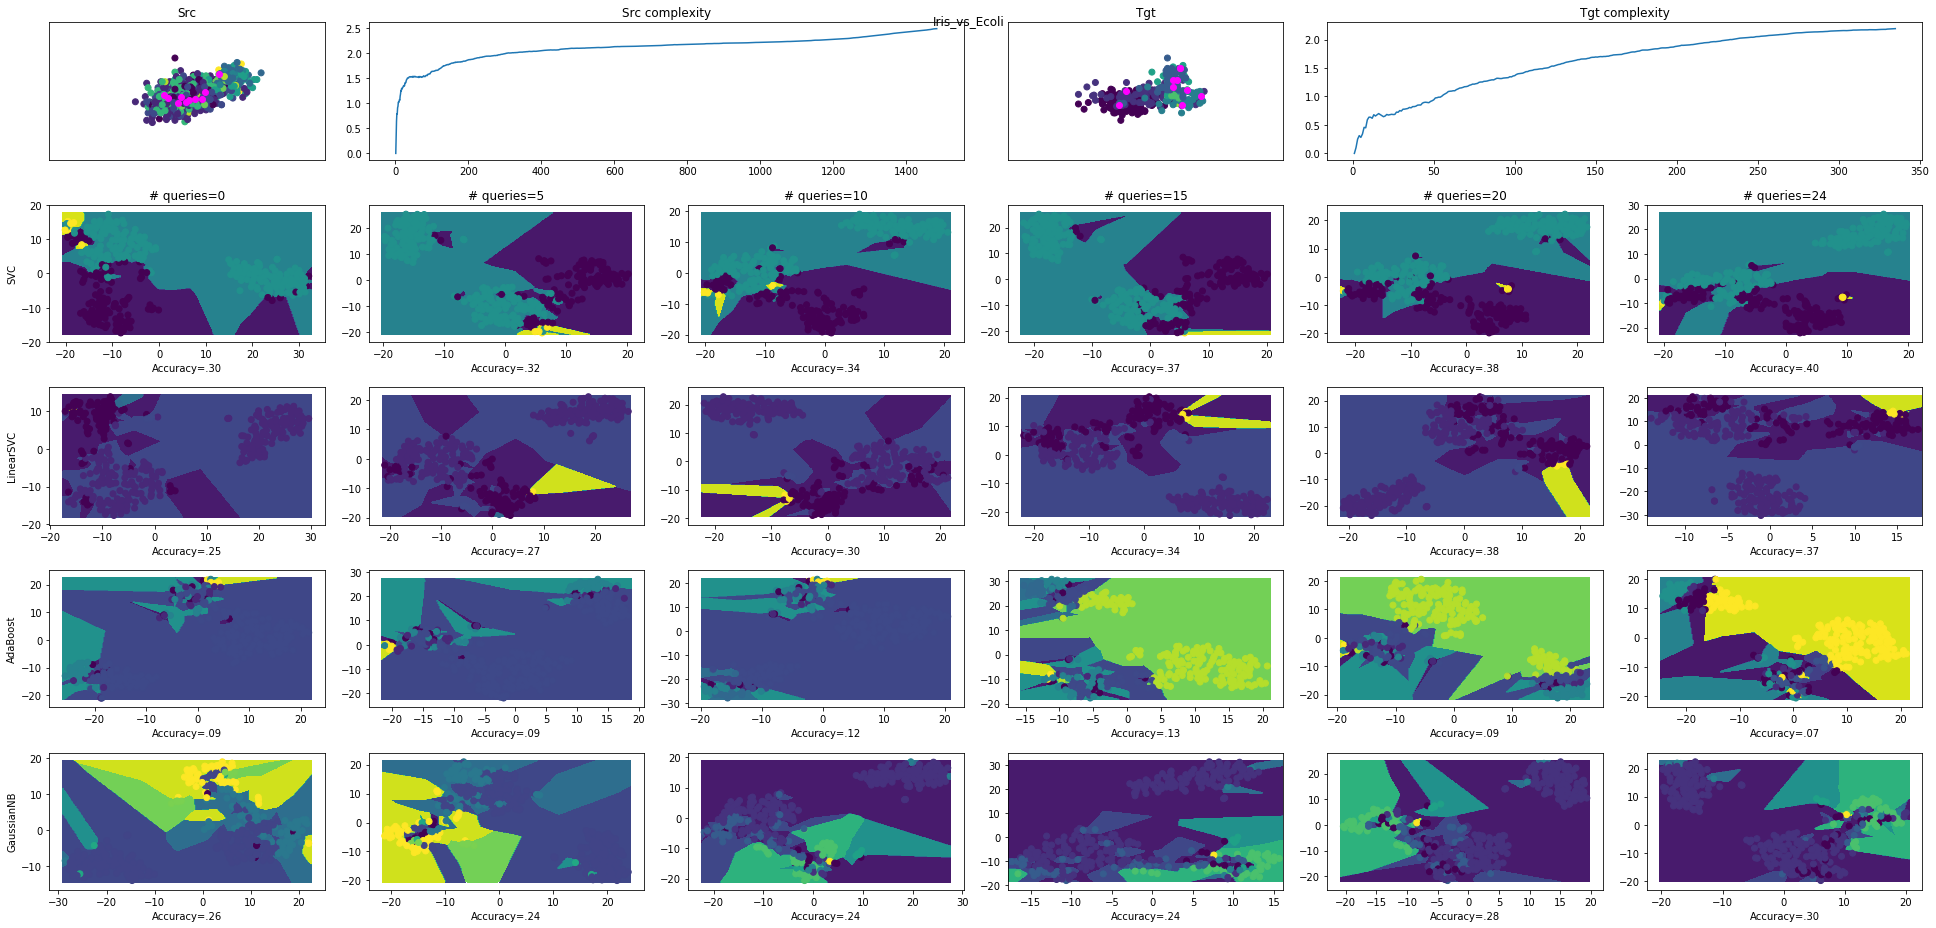

In [71]:
clfs = [SVC(), LinearSVC(), AdaBoostClassifier(), GaussianNB()]
datasets = []
experiments = []

datasets.append((load_yeast_data(), load_ecoli_data()))
experiments.append('Yeast_vs_Ecoli')
# datasets.append((u.hastie(500), make_gaussian_quantiles(n_samples=500, n_features=10, n_classes=2)))
# experiments.append('hastie_10_2_vs_gauss_quant_10_2')
# datasets.append((make_moons(), make_circles()))
# experiments.append('moons')
# datasets.append((make_blobs(), make_blobs()))
# experiments.append('blobs')

active(classifiers=clfs, datasets=datasets, experiments=experiments)